In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import truncnorm

In [52]:
class My_Neural_Network():
  def __init__(self, layers_list,
               activation_functions,weight_initializer, 
               learning_rate,lambd,
               drop_rate, sgd):

    self.layers_list = layers_list
    self.activation_functions = activation_functions
    self.weight_initializer = weight_initializer
    self.learning_rate = learning_rate
    self.lambd = lambd
    self.drop_rate = drop_rate
    self.sgd = sgd



  def sigmoid(self,Z):
    """ Arg: Linear activation Z
        return: Sigmoid of Z
    """
    return 1/(1+np.exp(-Z))

  def sigmoid_derivative(self,dA,Z):
    """ Arg: Derivative of Loss w.r.t activation (dL/dAl), Linear activation Z
        return: dL/dZl = (dL/dAl)*(dAl/dZl)
                (dAl/dZl) = Derivative of activation w.r.t linear activation(Z)
    """
    dZl = self.sigmoid(Z)*(1-self.sigmoid(Z))

    return dA*dZl

  def relu(self,Z):
    """ Arg: Linear activation Z
        return: Relu of Z
    """
    return np.maximum(0,Z)

  def relu_derivative(self,dA,Z):
    """ Arg: Derivative of Loss w.r.t activation (dL/dAl), Linear activation Z
        return: dL/dZl = (dL/dAl)*(dAl/dZl)
                (dAl/dZl) = Derivative of activation w.r.t linear activation(Z)
    """
    
    dZ = Z.copy()

    dZ = np.array(dZ>0, dtype=np.float32)


    return dA*dZ


  def softmax(self,Z):
    #print(Z.shape)
    e = np.exp(Z)
    e_total = np.sum(e, axis=0, keepdims=True)
    #print(e.shape, e_total.shape)
    
    return np.divide(e,e_total)




  def initialize_params(self, layers_list, method):
    """ Args: layers_list : containing the number of neurons (nodes) for each layer in the netwrok.
              method: a tuple. method[0] contains type of initialization (random/trunc_normal)
                                method[1] contains multiplying_factor for random initialization
                                          contains (mean, sd,low,upp) for truncated_normal
        returns: Initialized parameters : Weights (W), Bias (b) for each layers in a dictionary data structure.

    """

    params = {}
    num_layers = len(layers_list)
    if method == 'random':
      mult_factor = 0.01
      for l in range(1,num_layers):
        params['W' + str(l)] = np.random.randn(layers_list[l], layers_list[l-1])*mult_factor
        params['b' + str(l)] = np.zeros((layers_list[l], 1))

    if method == 'trunc_normal':
      mean, sd,low,upp = 0, 1, -0.5, 0.5
      for l in range(1, num_layers):
        temp = truncnorm((low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)
        params['W' + str(l)] = temp.rvs((layers_list[l], layers_list[l-1]))
        params['b' + str(l)] = np.zeros((layers_list[l], 1))

    if method == 'zeros':
      for l in range(1,num_layers):
        params['W' + str(l)] = np.zeros((layers_list[l], layers_list[l-1]))
        params['b' + str(l)] = np.zeros((layers_list[l], 1))


    if method == 'he':
      for l in range(1,num_layers):
        params['W' + str(l)] = np.random.randn(layers_list[l], layers_list[l-1])*np.sqrt(2/layers_list[l-1])
        params['b' + str(l)] = np.zeros((layers_list[l], 1))

    if method == 'xavier':
      for l in range(1,num_layers):
        params['W' + str(l)] = np.random.randn(layers_list[l], layers_list[l-1])*np.sqrt(1/layers_list[l-1])
        params['b' + str(l)] = np.zeros((layers_list[l], 1))

    return params


  def linear_activation(self, W,b,A,activation_function):
    """
    Args: W,b - parameters for the current layer; 
          A- linear activation (Z = WA_prev + b) for the current layer;
          activation_function
    returns: A_forward, memories of current activation, dropout memory (if dropout)
    """

    Z_current = np.dot(W,A) + b
    #Z_current = np.squeeze(Z_current)
    #print(Z_current.shape)
    #print(Z_current)
    linear_memory = (A,W,b)
    drop_flag = 0
    if activation_function == 'sigmoid':
      A_current = self.sigmoid(Z_current)

    if activation_function == 'relu':
      A_current= self.relu(Z_current)

    if activation_function == 'relu+dropout':
      A_current= self.relu(Z_current)
      D_current = np.random.rand(A_current.shape[0], A_current.shape[1])
      D_current = (D_current < (1- self.drop_rate)).astype(int)
      A_current = A_current*D_current
      A_current = A_current/(1- self.drop_rate)
      drop_flag = 1

    
    if activation_function == 'sigmoid+dropout':
      A_current= self.sigmoid(Z_current)
      D_current = np.random.rand(A_current.shape[0], A_current.shape[1])
      D_current = (D_current < (1- self.drop_rate)).astype(int)
      A_current = A_current*D_current
      A_current = A_current/(1- self.drop_rate)
      drop_flag = 1
      

    if activation_function == 'softmax':
      A_current = self.softmax(Z_current)

    if drop_flag == 0:
      memory_current = (linear_memory, Z_current)
    else:
      memory_current = (linear_memory, Z_current, D_current)
    return (A_current, memory_current)



  def forward_propagation(self, A0, params, activation_functions):
    """ 
    Args: A0 - X input
          params - dictionary containing W and b for all the layers
          activation_functions containing activation function used in all the layers (['relu',...,'sigmoid','softmax'])
    returns: Activation output of last layer and the memory (W,b,Z,A) in each layer
    """
    num_layers = len(params)//2
    #print(f'shape of num_layers : {num_layers}')
    memory = []
    A_current = A0
    for l in range(1,num_layers):
      W_current = params['W' + str(l)]
      b_current = params['b' + str(l)]
      A_prev = A_current
      #print(f'W : {W_current.shape} A : {A_current.shape}')
      A_current, memory_current = self.linear_activation(W_current, b_current, A_prev, activation_functions[l])
      memory.append(memory_current)
    
    W_current = params['W'+str(num_layers)]
    b_current = params['b'+str(num_layers)]
    #print("Activation for lasy layer : ", activation_functions[num_layers])
    A_last, memory_current = self.linear_activation(W_current, b_current, A_current, activation_functions[num_layers])
    memory.append(memory_current)  
    #print('Output vs input shape of FWD prop:',A_last.shape, A0.shape)
    #print(memory_current)
    #print(memory)
    return A_last, memory





  def calculate_cost(self, A_last, Y):
    #print('cost : ', Y.shape)
    m = Y.shape[1]
    #print(Y.shape, A_last.shape)
    part1 = Y*np.log(A_last)

    cost = (-1/m)*np.sum(part1)
    cost = np.squeeze(cost)
    return cost


  def calculate_cost_L2_regularised(self, A_last, Y, parameters, lambd):
    m = Y.shape[1]
    L = len(parameters)//2
    cost_without_reg = self.calculate_cost(A_last, Y)
    L2_reg = 0
    for l in range(1,L+1):
      W = parameters['W' + str(l)]
      L2_reg += np.sum(np.square(W))

    L2_reg = (lambd/(2*m))*L2_reg

    
    cost = cost_without_reg + L2_reg
    
    return cost

  def linear_backward(self,dA, memory, activation_function):
    """ 
    Args: dA - derivative of next layer output w.r.t A of current layer
          memory - contains values of Z,W,b,A for corresponding layer stored while forward propagation.
          activation_function - 'relu'/'sigmoid'
    returns: dA_previous (dL/dAl-1) - derivative of cost w.r.t activation of previous layers, 
            dW (dL/dWl)- derivative of cost w.r.t weight W of current layer
            db (dL/db) -  derivative of cost w.r.t bias b of current layer
    """
    
    if self.drop_rate ==0:
      A_previous, W, b = memory[0]
      Z = memory[1]
    else:
      A_previous, W, b = memory[0]
      Z = memory[1]
      D = memory[2]


    m = A_previous.shape[1]

    if activation_function == 'relu':
      dZ = self.relu_derivative(dA,Z)

    elif activation_function == 'sigmoid':
      dZ = self.sigmoid_derivative(dA,Z)

    elif activation_function == 'relu+dropout':
      dA = dA*D
      dA = dA/(1-self.drop_rate)
      dZ = self.relu_derivative(dA,Z)


    elif activation_function == 'sigmoid+dropout':
      dA = dA*D
      dA = dA/(1-self.drop_rate)
      dZ = self.sigmoid_derivative(dA,Z)




    
    dW = (1/m)*np.dot(dZ, A_previous.T)
    db = (1/m)*np.sum(dZ, axis=1, keepdims=True)
    dA_previous = np.dot(W.T,dZ)

    return dA_previous, dW, db


  def backward_propagation(self,A_last, Y, memory, activation_functions):
    
    num_layers = len(memory)
    grads = {}
    Y = Y.reshape(A_last.shape)
    m = Y.shape[1]

    #dA_last = A_last - Y

    memory_current = memory[-1] #(A_L-1,W_L,b_L), Z_last(output of softmax layer)
    dZ_last = A_last - Y

    A_previous, W, b = memory_current[0]
    
    dW_current = (1/m)*np.dot(dZ_last, A_previous.T)
    db_current = (1/m)*np.sum(dZ_last, axis=1, keepdims=True)
    dA_previous = np.dot(W.T,dZ_last)

    #dW_current, db_current = linear_backward(dZ_last, memory_current, activation_functions[-1])
      
    grads["dA" + str(num_layers-1)] = dA_previous
    grads["dW" + str(num_layers)] = dW_current
    grads["db" + str(num_layers)] = db_current

    for l in range(num_layers-2,-1,-1):
      memory_current = memory[l]
      #print('flkqenfnejnqn ', activation_functions[l])
      dA_previous = grads["dA" + str(l+1)]
      dA_previous, dW_current, db_current = self.linear_backward(dA_previous, memory_current, activation_functions[l])
      
      grads["dA" + str(l)] = dA_previous
      grads["dW" + str(l+1)] = dW_current
      grads["db" + str(l+1)] = db_current


    return grads


  def backward_propagation_L2_regularised(self, A_last, Y, memory, activation_functions, lambd):
    
    num_layers = len(memory)
    grads = {}
    Y = Y.reshape(A_last.shape)
    m = Y.shape[1]

    memory_current = memory[-1] #(A_L-1,W_L,b_L), Z_last(output of softmax layer)
    dZ_last = A_last - Y

    A_previous, W, b = memory_current[0]
    
    dW_current = (1/m)*np.dot(dZ_last, A_previous.T) + (lambd/m)*W
    db_current = (1/m)*np.sum(dZ_last, axis=1, keepdims=True)
    dA_previous = np.dot(W.T,dZ_last)

    #dW_current, db_current = linear_backward(dZ_last, memory_current, activation_functions[-1])
      
    grads["dA" + str(num_layers-1)] = dA_previous
    grads["dW" + str(num_layers)] = dW_current
    grads["db" + str(num_layers)] = db_current

    for l in range(num_layers-2,-1,-1):
      memory_current = memory[l]
      #print('flkqenfnejnqn ', activation_functions[l])
      dA_previous = grads["dA" + str(l+1)]
      dA_previous, dW_current, db_current = self.linear_backward(dA_previous, memory_current, activation_functions[l])

      A_previous_, W_, b_ = memory_current[0] #fetching memory cache
      dW_current += (lambd/m)*W_    #adding L2 regularised term
      
      grads["dA" + str(l)] = dA_previous
      grads["dW" + str(l+1)] = dW_current
      grads["db" + str(l+1)] = db_current


    return grads

  def gradient_descent(self,params, grads, learning_rate):
    """
    Args: params - initialized parameters (W,b). {W1:__, b1:__}
          grads - calculated gradients dictionary during backward_propagation
          learning_rate - alpha of gradient descent

    return : updated params dictionary
    """
    num_layers = len(params)//2
    updated_params = params.copy()
    for l in range(1,num_layers+1):
      updated_params['W' + str(l)] -= learning_rate*grads['dW' + str(l)]
      updated_params['b' + str(l)] -= learning_rate*grads['db' + str(l)]

    return updated_params

  def initialize_adam_moments(self, parameters):
    """
    Args: paramters dict including W and b for all layers
    return: v dict and s dict containing velocities and squared velocities initi
            - lized to zeros.
    """
    num_layers = len(parameters)//2
    v = {}
    s = {}
    for l in range(1,num_layers+1):
        v["dW" + str(l)] = np.zeros(parameters["W" + str(l)].shape)
        v["db" + str(l)] = np.zeros(parameters["b" + str(l)].shape)
        s["dW" + str(l)] = np.zeros(parameters["W" + str(l)].shape)
        s["db" + str(l)] = np.zeros(parameters["b" + str(l)].shape)

    return v,s

  

  def adam(self,params, grads, v, s,adam_counter, learning_rate, beta1, beta2,  epsilon):
    """
    Args: params - initialized parameters (W,b). {W1:__, b1:__}
          grads - calculated gradients dictionary during backward_propagation
          learning_rate - alpha of gradient descent

    return : updated params dictionary
    """
    num_layers = len(params)//2
    v_final, s_final = {}, {}
    updated_params = params.copy()

    for l in range(1,num_layers+1):
        v["dW" + str(l)] = beta1*v["dW" + str(l)] + (1 - beta1)*grads['dW' + str(l)]
        v["db" + str(l)] = beta1*v["db" + str(l)] + (1 - beta1)*grads['db' + str(l)]   
        v_final["dW" + str(l)] = v["dW" + str(l)]/(1 - beta1**adam_counter)
        v_final["db" + str(l)] =  v["db" + str(l)]/(1 - beta1**adam_counter) 

        s["dW" + str(l)] = beta2*s["dW" + str(l)] + (1 - beta2)*np.square(grads['dW' + str(l)])
        s["db" + str(l)] = beta2*s["db" + str(l)] + (1 - beta2)*np.square(grads['db' + str(l)])
        s_final["dW" + str(l)] = s["dW" + str(l)]/(1 - beta2**adam_counter)
        s_final["db" + str(l)] = s["db" + str(l)]/(1 - beta2**adam_counter)    

        updated_params["W" + str(l)] -= learning_rate*v_final["dW" + str(l)]/(np.sqrt(s_final["dW" + str(l)]) + epsilon)
        updated_params["b" + str(l)] -= learning_rate*v_final["db" + str(l)]/(np.sqrt(s_final["db" + str(l)]) + epsilon)



    return updated_params, v, s, v_final, s_final




  def train(self,X,Y,epochs, optimizer, beta1=0.9, beta2=0.99,epsilon=1e-8,print_cost=True):

      # MY MODEL:
      """
      def initialize_params(layers_list, method):
          ...
          return parameters 
      def forward_propagation(A0, params, activation_functions):
          ...
          return A_last, [((A_L-1,W_L,b_L), Z_last),
                          ((A_L-2,W_L-1,b_L-1), Z_last-1),
                          ((A_L-3,W_L-2,b_L-2), Z_last-2)
                          .
                          .
                          .
                          ((A0(X),W_1,b_1), Z_1)]
      def calculate_cost(A_last, Y):
          ...
          return cost
      def backward_propagation(A_last, Y, memory, activation_functions):
          ...
          return {dAL-1, dWL, dbL,
                  dAL-2, dWL-1, dbL-1,
                  .
                  .
                  .
                  dA0, dW1, db1}
      def gradient_descent(params, grads, learning_rate):
          ...
          return updated_parameters
      """


      np.random.seed(1)
      costs = []               
      m = X.shape[1]
      params = self.initialize_params(self.layers_list, self.weight_initializer) #initlizing weights:
      adam_counter = 0

      #initilizing moments (adam):
      if optimizer == 'adam':
        v,s = self.initialize_adam_moments(params)

      #lopping for number of iterations:

      if self.sgd == True:
        for i in range(0, epochs):
          total_cost = 0
          for j in range(0,m):
            
            # Forward propagation:
            #print(np.reshape(X[:,j],(X.shape[0],1)))
            A_last, memory = self.forward_propagation(np.reshape(X[:,j],(X.shape[0],1)), params, self.activation_functions)
            #print('A Last : ',A_last.shape)
            # Compute cost.

            if self.lambd == 0:
              total_cost += self.calculate_cost(A_last, np.reshape(Y[:,j],(Y.shape[0],1)))
            else:
              total_cost += self.calculate_cost_L2_regularised(A_last, np.reshape(Y[:,j],(Y.shape[0],1)), params, self.lambd)
            #print('Cost : ',cost)
            # Backward propagation.
            if self.lambd==0:
              grads = self.backward_propagation(A_last, np.reshape(Y[:,j],(Y.shape[0],1)), memory, self.activation_functions)
            elif self.lambd !=0:
              grads = self.backward_propagation_L2_regularised(A_last, np.reshape(Y[:,j],(Y.shape[0],1)), memory, self.activation_functions, self.lambd)
            # Update parameters.
            if optimizer == 'adam':
              adam_counter += 1
              params, v, s, _, _ = self.adam(params, grads, v, s,adam_counter, learning_rate, beta1, beta2,  epsilon)
            else:
              params = self.gradient_descent(params, grads, self.learning_rate)

          cost = total_cost/m
          
          # Print the cost every iterations
          print("Cost after iteration {}: {}".format(i+1, np.squeeze(cost)))
          costs.append(cost)

      else:
        for i in range(0, epochs):

            # Forward propagation:
            
            A_last, memory = self.forward_propagation(X, params, self.activation_functions)
            
            #print('A last shape : ', A_last.shape)
            #print('memory : ', memory.keys())

            # Compute cost.
            if self.lambd == 0:
              cost = self.calculate_cost(A_last, Y)
            else:
              cost = self.calculate_cost_L2_regularised(A_last, Y, params, self.lambd)
            #cost = self.calculate_cost(A_last, self.Y)
                    
            # Backward propagation.
            if self.lambd==0:
              grads = self.backward_propagation(A_last, Y, memory, self.activation_functions)
            elif self.lambd !=0:
              grads = self.backward_propagation_L2_regularised(A_last, Y, memory, self.activation_functions, self.lambd)
          

            
            # Update parameters.
            params = self.gradient_descent(params, grads, self.learning_rate)
          
            # Print the cost every 10 iterations
            if print_cost and i % 10 == 0 or i == epochs - 1:
                print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
            if i % 10 == 0 or i == epochs:
                costs.append(cost)
        
      return params, costs


  def predict(self,input_x,final_params):
    y_pred_scores, memory_pred = self.forward_propagation(input_x, final_params, self.activation_functions)
    y_pred = np.argmax(y_pred_scores,axis=0)

    return y_pred, y_pred_scores

  def accuracy(self,y_pred, y_actual):
    acc = np.sum(np.equal(y_actual, y_pred)) / len(y_actual)
    return acc



    

In [19]:
class Data():
  def visualize(self, rows, cols):
    plt.figure(figsize=(12,8))
    for i in range(rows*cols):
      plt.subplot(2,3,i+1)
      plt.imshow(train_x_orig[i])


  def getInfo(self, train_x_orig, train_y, test_x_orig, test_y):
    print('X Train data size : ', train_x_orig.shape)
    print('Y Train data size : ', train_y.shape)
    print('X Test data size : ', test_x_orig.shape)
    print('Y Test data size : ', test_y.shape)
    print('='*50)
    #print('Total training examples : ', train_y.shape[0] )


  def preprocess_data(self,train_x_orig, train_y, test_x_orig, test_y, n_classes):
    m_train = train_y.shape[0]
    X_train = train_x_orig.reshape(m_train, -1).T
    X_train = X_train/255.
    y_train = to_categorical(train_y,n_classes)
    y_train = y_train.T
    

    m_test = test_y.shape[0]
    X_test = test_x_orig.reshape(m_test, -1).T
    X_test = X_test/255.
    y_test = to_categorical(test_y,n_classes)
    y_test = y_test.T
  

    self.getInfo(X_train, y_train, X_test, y_test)
    
    return (X_train, y_train, X_test, y_test)
    

  

In [20]:

#Test Suits:

layers_list = [784, 256,64, 10]
activation_functions = ['relu','relu','relu','softmax']
weight_initializer = 'he'
learning_rate = 0.1
lambd = 0
drop_rate=0

sgd = False

my_model = My_Neural_Network(layers_list,activation_functions, weight_initializer,learning_rate,lambd,drop_rate, sgd)

def test_suit_gradient_descent():

    parameters = {'W1': np.array([[ 1.63535156, -0.62320365, -0.53718766],
                          [-1.07799357,  0.85639907, -2.29470142]]),
                  'b1': np.array([[ 1.74604067],
                          [-0.75184921]]),
                  'W2': np.array([[ 0.32171798, -0.25467393,  1.46902454],
                          [-2.05617317, -0.31554548, -0.3756023 ],
                          [ 1.1404819 , -1.09976462, -0.1612551 ]]),
                  'b2': np.array([[-0.88020257],
                          [ 0.02561572],
                          [ 0.57539477]])}
    grads = {'dW1': np.array([[-1.10061918,  1.14472371,  0.90159072],
                      [ 0.50249434,  0.90085595, -0.68372786]]),
              'db1': np.array([[-0.12289023],
                      [-0.93576943]]),
              'dW2': np.array([[-0.26788808,  0.53035547, -0.69166075],
                      [-0.39675353, -0.6871727 , -0.84520564],
                      [-0.67124613, -0.0126646 , -1.11731035]]),
              'db2': np.array([[0.2344157 ],
                      [1.65980218],
                      [0.74204416]])}
    learning_rate = 0.01

    params = my_model.gradient_descent(parameters, grads, learning_rate)
    W1 = params['W1']
    W2 = params['W2']
    b1 = params['b1']
    b2 = params['b2']
  
    W1_0 = parameters['W1']
    W2_0 = parameters['W2']
    b1_0 = parameters['b1']
    b2_0 = parameters['b2']




    assert W1.shape == W1_0.shape
    assert b1.shape == b1_0.shape
    assert W2.shape == W2_0.shape
    assert b2.shape == b2_0.shape
    
    assert (np.round(np.sum(W1),4) == np.round(np.sum(np.array([[ 1.64635775, -0.63465089, -0.54620357],[-1.08301851,  0.84739051, -2.28786414]])),4))
    assert (np.round(np.sum(b1),4) == np.round(np.sum(np.array([[ 1.74726957],[-0.74249152]])),4))
    assert (np.round(np.sum(W2),4) == np.round(np.sum(np.array([[  0.32439686, -0.25997748,  1.47594115], [-2.05220563, -0.30867375, -0.36715024 ], [ 1.14719436, -1.09963797, -0.150082 ]])),4))
    assert (np.round(np.sum(b2),4) == np.round(np.sum(np.array([[-0.88254673], [ 0.0090177], [ 0.56797433]])),4))



    print("gradient_descent working CORRECTLY.")

  
#test_suit_gradient_descent()

def test_initialize_params():
    layers_list = [64,32,16,10]
    methods = ['trunc_normal','he','xavier','zeros','random']
    W1_shape, b1_shape = (32,64), (32,1)
    W2_shape, b2_shape = (16,32), (16,1)
    W3_shape, b3_shape = (10,16), (10,1)
    for method in methods:
      params = my_model.initialize_params(layers_list, method='random')
      W1,b1 = params['W1'], params['b1']
      W2,b2 = params['W2'], params['b2']
      W3,b3 = params['W3'], params['b3']
      #print(b2.shape)
      assert len(params) == (len(layers_list)-1)*2
      assert W1.shape == (32,64)
      assert b1.shape == (32,1)
      assert W2.shape == (16,32)
      assert b2.shape == (16,1)
      assert W3.shape == (10,16)
      assert b3.shape == (10,1)

      print(f"{method} weight initialzation working CORRECTLY")
#test_initialize_params()   

def test_linear_activation():
    W = np.array([[ 0.50288142, -1.24528809, -1.05795222]])
    b = np.array([[-0.90900761]])
    A = np.array([[-0.41675785, -0.05626683],
        [-2.1361961 ,  1.64027081],
        [-1.79343559, -0.84174737]])
    activation_functions = ['relu','sigmoid']

    (A_current, memory_current) = my_model.linear_activation(W,b,A,'sigmoid')
    assert np.round(np.sum(A_current),4) == np.round(np.sum(np.array([[0.96890023, 0.11013289]])),4)
    (A_current, memory_current) = my_model.linear_activation(W,b,A,'relu')
    assert np.round(np.sum(A_current),4) == np.round(np.sum(np.array([[3.43896131, 0.        ]])),4)

    print("linear_activation working CORRECTLY")

#test_linear_activation()


def test_forward_propagation():
    A0 = np.array([[-0.31178367,  0.72900392,  0.21782079, -0.8990918 ],
        [-2.48678065,  0.91325152,  1.12706373, -1.51409323],
        [ 1.63929108, -0.4298936 ,  2.63128056,  0.60182225],
        [-0.33588161,  1.23773784,  0.11112817,  0.12915125],
        [ 0.07612761, -0.15512816,  0.63422534,  0.810655  ]])
    
    params = {'W1': np.array([[ 0.35480861,  1.81259031, -1.3564758 , -0.46363197,  0.82465384],
                    [-1.17643148,  1.56448966,  0.71270509, -0.1810066 ,  0.53419953],
                    [-0.58661296, -1.48185327,  0.85724762,  0.94309899,  0.11444143],
                    [-0.02195668, -2.12714455, -0.83440747, -0.46550831,  0.23371059]]),
              'b1': np.array([[ 1.38503523],
                    [-0.51962709],
                    [-0.78015214],
                    [ 0.95560959]]),
              'W2': np.array([[-0.12673638, -1.36861282,  1.21848065, -0.85750144],
                    [-0.56147088, -1.0335199 ,  0.35877096,  1.07368134],
                    [-0.37550472,  0.39636757, -0.47144628,  2.33660781]]),
              'b2': np.array([[ 1.50278553],
                    [-0.59545972],
                    [ 0.52834106]]),
              'W3': np.array([[ 0.9398248 ,  0.42628539, -0.75815703]]),
              'b3': np.array([[-0.16236698]])}
             
    activation_functions = ['relu','relu','relu','sigmoid']
    A_last, memory = my_model.forward_propagation(A0, params, activation_functions)
    assert np.round(np.sum(A_last),4) == np.round(np.sum(np.array([[0.03921668, 0.70498921, 0.19734387, 0.04728177]])),4)
    print("forward_propagation working CORRECTLY")


#test_forward_propagation()

def test_linear_backward():
    dA = np.array([[-0.41675785, -0.05626683]])
    #Z,W,b,A
    # memory[0] = A_prev, W,b
    # memory[1] = 
    memory = (
              (np.array([[-2.1361961 ,  1.64027081],
                      [-1.79343559, -0.84174737],
                      [ 0.50288142, -1.24528809]]),
              np.array([[-1.05795222, -0.90900761,  0.55145404]]),
              np.array([[2.29220801]])),
              np.array([[ 0.04153939, -1.11792545]])
              )
    activation_function = ['relu','relu','relu','sigmoid']
    dA_previous, dW, db = my_model.linear_backward(dA, memory, 'sigmoid')
    assert np.round(np.sum(dA_previous),4) == np.round(np.sum(np.array([[ 0.11017994,  0.01105339],[ 0.09466817,  0.00949723],[-0.05743092, -0.00576154]])),4)
    assert np.round(np.sum(dW),4) == np.round(np.sum(np.array([[ 0.10266786,  0.09778551, -0.01968084]])),4)
    assert np.round(np.sum(db),4) == np.round(np.sum(np.array([[-0.05729622]])),4)
    dA_previous, dW, db = my_model.linear_backward(dA, memory, 'relu')
    assert np.round(np.sum(dA_previous),4) == np.round(np.sum(np.array([[ 0.44090989,  0.        ],[ 0.37883606,  0.],[-0.2298228,   0.        ]])),4)
    assert np.round(np.sum(dW),4) == np.round(np.sum(np.array([[ 0.44513824,  0.37371418, -0.10478989]])),4)
    assert np.round(np.sum(db),4) == np.round(np.sum(np.array([[-0.20837892]])),4)
    print('linear_backward working CORRECTLY')         


def adam_test():
    params = {'W1': np.array([[ 1.62434536, -0.61175641, -0.52817175],
                    [-1.07296862,  0.86540763, -2.3015387 ]]),
              'b1': np.array([[ 1.74481176],
                    [-0.7612069 ]]),
              'W2': np.array([[ 0.3190391 , -0.24937038,  1.46210794],
                    [-2.06014071, -0.3224172 , -0.38405435],
                    [ 1.13376944, -1.09989127, -0.17242821]]),
              'b2': np.array([[-0.87785842],
                    [ 0.04221375],
                    [ 0.58281521]])}
    grads = {'dW1': np.array([[-1.10061918,  1.14472371,  0.90159072],
                  [ 0.50249434,  0.90085595, -0.68372786]]),
            'db1': np.array([[-0.12289023],
                  [-0.93576943]]),
            'dW2': np.array([[-0.26788808,  0.53035547, -0.69166075],
                  [-0.39675353, -0.6871727 , -0.84520564],
                  [-0.67124613, -0.0126646 , -1.11731035]]),
            'db2': np.array([[0.2344157 ],
                  [1.65980218],
                  [0.74204416]])}
              
    v0 = {'dW1': np.array([[0., 0., 0.],
                [0., 0., 0.]]),
          'dW2': np.array([[0., 0., 0.],
                [0., 0., 0.],
                [0., 0., 0.]]),
          'db1': np.array([[0.],
                [0.]]),
          'db2': np.array([[0.],
                [0.],
                [0.]])}
    s0 = {'dW1': np.array([[0., 0., 0.],
              [0., 0., 0.]]),
        'dW2': np.array([[0., 0., 0.],
              [0., 0., 0.],
              [0., 0., 0.]]),
        'db1': np.array([[0.],
              [0.]]),
        'db2': np.array([[0.],
              [0.],
              [0.]])}
    adam_counter, learning_rate, beta1, beta2, epsilon = (2, 0.02, 0.8, 0.888, 0.01)

    updated_params, v, s, v_final, s_final = my_model.adam(params, grads, v0, s0,adam_counter, learning_rate, beta1, beta2,  epsilon)

    W1 = updated_params['W1']
    W2 = updated_params['W2']
    b1 = updated_params['b1']
    b2 = updated_params['b2']

    W1_0 = params['W1']
    W2_0 = params['W2']
    b1_0 = params['b1']
    b2_0 = params['b2']




    assert W1.shape == W1_0.shape
    assert b1.shape == b1_0.shape
    assert W2.shape == W2_0.shape
    assert b2.shape == b2_0.shape
    
    #print(np.sum(W1))
    #print(np.round(np.sum(np.array([[ 1.63942428, -0.6268425,  -0.54320974],[-1.08782943,  0.85036983, -2.2865723 ]])),4))
    assert (np.round(np.sum(W1),4) == np.round(np.sum(np.array([[ 1.63942428, -0.6268425,  -0.54320974],[-1.08782943,  0.85036983, -2.2865723 ]])),4))
    assert (np.round(np.sum(b1),4) == np.round(np.sum(np.array([[ 1.75854357],[-0.74616067]])),4))
    assert (np.round(np.sum(W2),4) == np.round(np.sum(np.array([[ 0.33356139, -0.26425199,  1.47707772],[-2.04538458, -0.30744933,-0.36903141],[ 1.14873036, -1.09256871, -0.15734651]])),4))
    assert (np.round(np.sum(b2),4) == np.round(np.sum(np.array([[-0.89228024],[ 0.02707193],[ 0.56782561]])),4))

    print('Adam working CORRECTLY') 


  


test_initialize_params()
test_linear_activation()
test_suit_gradient_descent()
test_forward_propagation()
test_linear_backward()
test_linear_backward()
adam_test()

trunc_normal weight initialzation working CORRECTLY
he weight initialzation working CORRECTLY
xavier weight initialzation working CORRECTLY
zeros weight initialzation working CORRECTLY
random weight initialzation working CORRECTLY
linear_activation working CORRECTLY
gradient_descent working CORRECTLY.
forward_propagation working CORRECTLY
linear_backward working CORRECTLY
linear_backward working CORRECTLY
Adam working CORRECTLY


11490434/11490434 [==============================] - 0s 0us/step
X Train data size :  (784, 60000)
Y Train data size :  (10, 60000)
X Test data size :  (784, 10000)
Y Test data size :  (10, 10000)


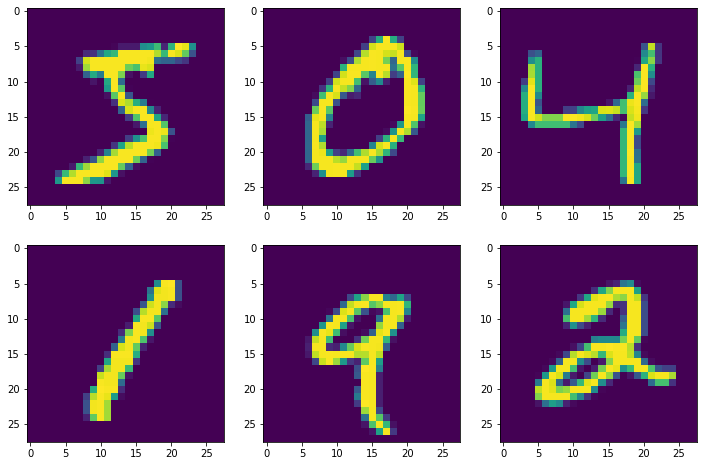

In [15]:
from keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

(train_x_orig, train_y), (test_x_orig, test_y) = mnist.load_data()
data = Data()
data.visualize(2,3)
X_train, y_train, X_test, y_test = data.preprocess_data(train_x_orig, train_y, test_x_orig, test_y, 10)

# Model 1

In [21]:

#without regularization

X = X_train
Y = y_train
input_shape = X_train.shape[0]
n_classes = len(np.unique(train_y))
layers_list = [input_shape, 64,64, n_classes]
activation_functions = ['relu','relu','relu','softmax']
weight_initializer = 'he'
learning_rate = 0.1
epochs = 300
lambd = 0
drop_rate=0
sgd = False




my_model = My_Neural_Network(layers_list,activation_functions, weight_initializer,learning_rate,lambd,drop_rate, sgd)


In [22]:
parameters, costs_gd =  my_model.train(X_train, y_train, epochs, optimizer='gd')

Cost after iteration 0: 2.4659753507045177
Cost after iteration 10: 1.6757711029235762
Cost after iteration 20: 1.1014606133801772
Cost after iteration 30: 0.7875214948869396
Cost after iteration 40: 0.6375185734175925
Cost after iteration 50: 0.5533101539921559
Cost after iteration 60: 0.4989292181898242
Cost after iteration 70: 0.4605230007638965
Cost after iteration 80: 0.4316528897197195
Cost after iteration 90: 0.4090047450781276
Cost after iteration 100: 0.39065555640229216
Cost after iteration 110: 0.3753984988191435
Cost after iteration 120: 0.36240822931005007
Cost after iteration 130: 0.3511616801228981
Cost after iteration 140: 0.34128458971647174
Cost after iteration 150: 0.3324911060727222
Cost after iteration 160: 0.3245799333922828
Cost after iteration 170: 0.3173980869858314
Cost after iteration 180: 0.31080964368683595
Cost after iteration 190: 0.3047182004620987
Cost after iteration 200: 0.2990584998595187
Cost after iteration 210: 0.29379449762430593
Cost after itera

Text(0, 0.5, 'Cost')

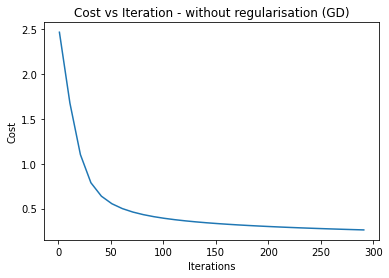

In [23]:
plt.plot(range(1,epochs,10),costs)
plt.title('Cost vs Iteration - without regularisation (GD)')
plt.xlabel('Iterations')
plt.ylabel('Cost')

In [24]:
y_pred, y_pred_scores = my_model.predict(X_test,parameters)
print(y_pred.shape, test_y.shape)
print('Test Accuracy : ',my_model.accuracy(y_pred, test_y))

y_pred, y_pred_scores = my_model.predict(X_train,parameters)
print(y_pred.shape, train_y.shape)
print('Train Accuracy : ',my_model.accuracy(y_pred, train_y))

(10000,) (10000,)
Test Accuracy :  0.9262
(60000,) (60000,)
Train Accuracy :  0.9264333333333333


### It will go further lower if I increase the number of epochs (iterations).

In [26]:

#with SGD

X = X_train
Y = y_train
input_shape = X_train.shape[0]
n_classes = len(np.unique(train_y))
layers_list = [input_shape, 64,64, n_classes]
activation_functions = ['relu','relu','relu','softmax']
weight_initializer = 'he'
learning_rate = 0.01
epochs = 20
lambd = 0
drop_rate=0
sgd = True




my_model = My_Neural_Network(layers_list,activation_functions, weight_initializer,learning_rate,lambd,drop_rate, sgd)


In [27]:
parameters, costs =  my_model.train(X_train, y_train,epochs,optimizer='gd')

Cost after iteration 1: 0.23009075644607202
Cost after iteration 2: 0.11968206896694397
Cost after iteration 3: 0.0920752556693331
Cost after iteration 4: 0.07481139414707651
Cost after iteration 5: 0.06410191844906422
Cost after iteration 6: 0.058087347885485384
Cost after iteration 7: 0.05598709726811135
Cost after iteration 8: 0.052591981563038986
Cost after iteration 9: 0.04950549117096619
Cost after iteration 10: 0.04886294306950877
Cost after iteration 11: 0.04128876981357508
Cost after iteration 12: 0.043589312657435236
Cost after iteration 13: 0.04712351857046731
Cost after iteration 14: 0.04020999024485311
Cost after iteration 15: 0.038526313553236255
Cost after iteration 16: 0.04403968995937765
Cost after iteration 17: 0.03706622589245673
Cost after iteration 18: 0.036643077012078175
Cost after iteration 19: 0.03515743442479911
Cost after iteration 20: 0.036780063887628785


Text(0, 0.5, 'Cost')

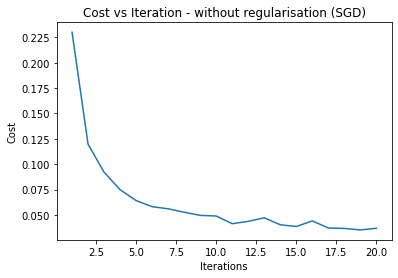

In [29]:
plt.plot(range(1,epochs+1),costs)
plt.title('Cost vs Iteration - without regularisation (SGD)')
plt.xlabel('Iterations')
plt.ylabel('Cost')

In [30]:
y_pred, y_pred_scores = my_model.predict(X_test,parameters)
print(y_pred.shape, test_y.shape)
print('Test Accuracy : ',my_model.accuracy(y_pred, test_y))

y_pred, y_pred_scores = my_model.predict(X_train,parameters)
print(y_pred.shape, train_y.shape)
print('Train Accuracy : ',my_model.accuracy(y_pred, train_y))

(10000,) (10000,)
Test Accuracy :  0.9716
(60000,) (60000,)
Train Accuracy :  0.9889333333333333


* SGD takes much more time than Batch gradient descent.
* SGD requires much much lesser epochs to achieve good results.
* SGD requires lower learning rate to converge.

In [19]:

#without regularization

X = X_train
Y = y_train
input_shape = X_train.shape[0]
n_classes = len(np.unique(train_y))
layers_list = [input_shape, 64,64, n_classes]
activation_functions = ['relu','relu','relu','softmax']
epochs=300
weight_initializer = 'he'
learning_rate = 0.1
lambd = 0
drop_rate=0
sgd = False




my_model = My_Neural_Network(layers_list,activation_functions, weight_initializer,learning_rate,lambd,drop_rate, sgd)


In [20]:
parameters, costs =  my_model.train(X_train, y_train,epochs, optimizer='adam')

Cost after iteration 0: 2.4659753507045177
Cost after iteration 10: 1.6757711029235762
Cost after iteration 20: 1.1014606133801772
Cost after iteration 30: 0.7875214948869396
Cost after iteration 40: 0.6375185734175925
Cost after iteration 50: 0.5533101539921559
Cost after iteration 60: 0.4989292181898242
Cost after iteration 70: 0.4605230007638965
Cost after iteration 80: 0.4316528897197195
Cost after iteration 90: 0.4090047450781276
Cost after iteration 100: 0.39065555640229216
Cost after iteration 110: 0.3753984988191435
Cost after iteration 120: 0.36240822931005007
Cost after iteration 130: 0.3511616801228981
Cost after iteration 140: 0.34128458971647174
Cost after iteration 150: 0.3324911060727222
Cost after iteration 160: 0.3245799333922828
Cost after iteration 170: 0.3173980869858314
Cost after iteration 180: 0.31080964368683595
Cost after iteration 190: 0.3047182004620987
Cost after iteration 200: 0.2990584998595187
Cost after iteration 210: 0.29379449762430593
Cost after itera

Text(0, 0.5, 'Cost')

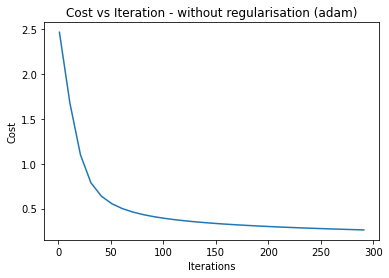

In [23]:
plt.plot(range(1,epochs+1,10),costs)
plt.title('Cost vs Iteration - without regularisation (adam)')
plt.xlabel('Iterations')
plt.ylabel('Cost')

In [24]:
y_pred, y_pred_scores = my_model.predict(X_test,parameters)
print(y_pred.shape, test_y.shape)
print('Test Accuracy : ',my_model.accuracy(y_pred, test_y))

y_pred, y_pred_scores = my_model.predict(X_train,parameters)
print(y_pred.shape, train_y.shape)
print('Train Accuracy : ',my_model.accuracy(y_pred, train_y))

(10000,) (10000,)
Test Accuracy :  0.9262
(60000,) (60000,)
Train Accuracy :  0.9264333333333333


In [27]:

#with regularization

X = X_train
Y = y_train
input_shape = X_train.shape[0]
n_classes = len(np.unique(train_y))
layers_list = [input_shape, 64,64, n_classes]
activation_functions = ['relu','relu','relu','softmax']
epochs=300
weight_initializer = 'he'
learning_rate = 0.1
lambd = 0.4
drop_rate=0
sgd = False




my_model = My_Neural_Network(layers_list,activation_functions, weight_initializer,learning_rate,lambd,drop_rate, sgd)


In [28]:
parameters, costs =  my_model.train(X_train, y_train,epochs, optimizer='adam')

Cost after iteration 0: 2.466897302723364
Cost after iteration 10: 1.676705941260727
Cost after iteration 20: 1.102418627617385
Cost after iteration 30: 0.7884901291005143
Cost after iteration 40: 0.6384951349520369
Cost after iteration 50: 0.5542932402126539
Cost after iteration 60: 0.49991805549503365
Cost after iteration 70: 0.4615166047179147
Cost after iteration 80: 0.43265122710408344
Cost after iteration 90: 0.41000699594403744
Cost after iteration 100: 0.3916611903438567
Cost after iteration 110: 0.37640786674711296
Cost after iteration 120: 0.36342113996192416
Cost after iteration 130: 0.3521777395988085
Cost after iteration 140: 0.34230373163677336
Cost after iteration 150: 0.33351319552771186
Cost after iteration 160: 0.3256046597228051
Cost after iteration 170: 0.31842543875057033
Cost after iteration 180: 0.3118394954622695
Cost after iteration 190: 0.3057506403274842
Cost after iteration 200: 0.3000934307820505
Cost after iteration 210: 0.29483211025844713
Cost after iter

Text(0, 0.5, 'Cost')

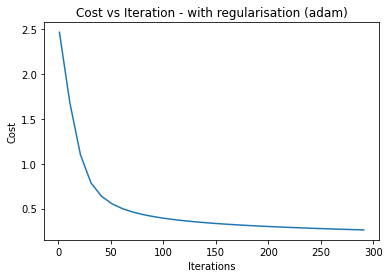

In [29]:
plt.plot(range(1,epochs+1,10),costs)
plt.title('Cost vs Iteration - with regularisation (adam)')
plt.xlabel('Iterations')
plt.ylabel('Cost')

In [30]:
y_pred, y_pred_scores = my_model.predict(X_test,parameters)
print(y_pred.shape, test_y.shape)
print('Test Accuracy : ',my_model.accuracy(y_pred, test_y))

y_pred, y_pred_scores = my_model.predict(X_train,parameters)
print(y_pred.shape, train_y.shape)
print('Train Accuracy : ',my_model.accuracy(y_pred, train_y))

(10000,) (10000,)
Test Accuracy :  0.9262
(60000,) (60000,)
Train Accuracy :  0.9264166666666667


### Since the model was already generalizing pretty well, regularization didnt change much. 

In [55]:

#with Dropout


X = X_train
Y = y_train
input_shape = X_train.shape[0]
n_classes = len(np.unique(train_y))
layers_list = [input_shape, 64,64, n_classes]
activation_functions = ['relu','relu+dropout','relu+dropout','softmax']
epochs=300
weight_initializer = 'he'
learning_rate = 0.1
lambd = 0
drop_rate=0.3
sgd = False




my_model = My_Neural_Network(layers_list,activation_functions, weight_initializer,learning_rate,lambd,drop_rate, sgd)




In [56]:

parameters, costs =  my_model.train(X_train, y_train,epochs, optimizer='adam')

Cost after iteration 0: 2.5812865148380033
Cost after iteration 10: 1.954430078005659
Cost after iteration 20: 1.610894193390232
Cost after iteration 30: 1.3859258408700734
Cost after iteration 40: 1.2422077966031388
Cost after iteration 50: 1.1471933270782586
Cost after iteration 60: 1.075788082370786
Cost after iteration 70: 1.0234125631044733
Cost after iteration 80: 0.9791476257325005
Cost after iteration 90: 0.9391051638340204
Cost after iteration 100: 0.9180720430845603
Cost after iteration 110: 0.8941641779663678
Cost after iteration 120: 0.875372698912925
Cost after iteration 130: 0.8480126600747135
Cost after iteration 140: 0.8378565764294215
Cost after iteration 150: 0.8278572136686452
Cost after iteration 160: 0.8143303082747355
Cost after iteration 170: 0.8081164921283264
Cost after iteration 180: 0.7894716814058638
Cost after iteration 190: 0.7831855959665319
Cost after iteration 200: 0.7735169873966278
Cost after iteration 210: 0.7704405688919898
Cost after iteration 220:

Text(0, 0.5, 'Cost')

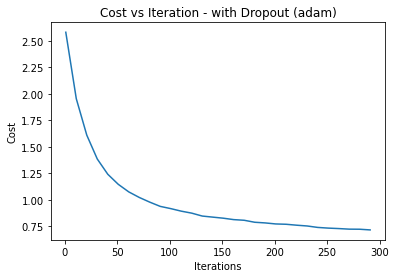

In [57]:
plt.plot(range(1,epochs+1,10),costs)
plt.title('Cost vs Iteration - with Dropout (adam)')
plt.xlabel('Iterations')
plt.ylabel('Cost')

In [58]:
y_pred, y_pred_scores = my_model.predict(X_test,parameters)
print(y_pred.shape, test_y.shape)
print('Test Accuracy : ',my_model.accuracy(y_pred, test_y))

y_pred, y_pred_scores = my_model.predict(X_train,parameters)
print(y_pred.shape, train_y.shape)
print('Train Accuracy : ',my_model.accuracy(y_pred, train_y))

(10000,) (10000,)
Test Accuracy :  0.7688
(60000,) (60000,)
Train Accuracy :  0.7681166666666667
